# Entrega 2 - Deep Learning

Segundo y último ejercicio entregable de la sección Redes Neuronales. En este caso, y como siempre,
tendréis opciones para escoger:
1. Melanomas: Nos contratan para trabajar en un proyecto oncológico de identificación: Si la
muestra es benigna o maligna.

In [1]:

# Librerías
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import PIL
from PIL import Image
import shutil



Para empezar, voy a cargar todos las imágenes que nos han proporcionado, y voy a cargarlas en el formato, dimensión y características que me interesen. En este primer caso, he decidido hacerlo con un tamaño de 64 píxeles. Además, con el ToTensor las transformamos en un tensor que nos va a permitir que la librería Tensor Flow las pueda entender. Y, por último, las vamos a normalizar. 

In [3]:
# Carga de Datos

# Definir transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensiona las imágenes a 64x64 píxeles
    transforms.ToTensor(),         # Convierte las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes
])

# Rutas de las carpetas de entrenamiento y prueba
train_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Cargar conjunto de datos de prueba
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Crear iteradores de carga de datos
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Una vez hemos cargado las imágenes, y antes de empezar con los modelos, vamos a visualizar alguna de las imágenes cargadas con un primer lote de 8 para comprobar que se han cargado correctamente.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


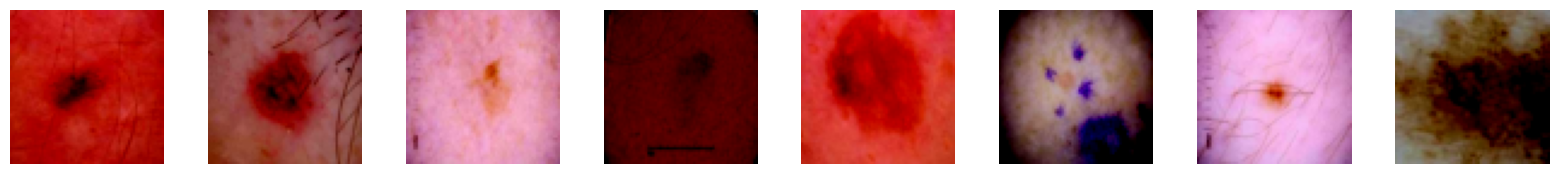

In [43]:
# Lote de imágenes
images, labels = next(iter(train_loader))

# Convertir las imágenes a NumPy arrays
images = images.numpy()

# Mostrar las primeras 8 imágenes del lote
fig, axes = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Transponer las dimensiones para que sean compatibles con imshow
    ax.axis('off')
plt.show()

Una vez vemos que las imágenes se han cargado correctamente, es importante conocer todas sus características. Aunque el número de píxeles lo he decidido yo, inicialmente no tenía claro el número de canales (igual lo tendría que saber), pero para asegurarme, lo vemos a continuación.

In [75]:
# Tamaño en píxeles y número de canales de las imágenes en blanco y negro
print("Tamaño en píxeles y número de canales de las imágenes en blanco y negro:")
for i, (images, _) in enumerate(train_loader):
    batch_size, channels, height, width = images.shape
    print(f"Tamaño de las imágenes en el lote {i+1}: {width}x{height} píxeles, {channels} canal(es)")
    break  # Solo imprimimos información sobre el primer lote


Tamaño en píxeles y número de canales de las imágenes en blanco y negro:
Tamaño de las imágenes en el lote 1: 64x64 píxeles, 3 canal(es)


Con esto, ya podemos definir la arquitectura de la red neuronal, añadiendo las características de las imágenes, como las queremos fracciónar, definir como haremos el pooling, las capas internas y el número de neuronas que queremos añadir.

Vamos a empezar con una primera convolución, aquí tenemos que poner los canales de entrada que tiene la imagen (los conocemos por el anterior código) y luego definimos la cantidad de capas en las que queremos segmentar nuestra imagen. A continuación hay una segunda convolución donde entramos con estasa 8 capas y salimos con 16 capas, en las que intentamos mantener el máximo de información posible. El self.pool, nos servira para dividr entre dos el tamaño de las imágenes gracias al pooling. Por último, vamos a multiplicar las 16 capas resultantes por el tamaño de las imágenes posterior al pooling entre dos, dos veces, ya que hemos realizado pooling dos veces. Hemos cargado estas imágenes con 64x64 píxeles, así que de aquí salen el 16*16. Por último, determinaremos el número de neuronas que vamos a incluir en el modelo.

In [79]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 96)
        self.fc2 = nn.Linear(96, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Una vez hemos creado la estructura, seleccionamos Cross Entropy com función y usaremos el optimizador más común, Adam.
 

También hay que escoger la cantidad de Epoch que le queremos dar a nuestra red neuronal para que entrene, conforme más le demos, más posibilidades de obtener mejores resultados, y a su vez, más opciones de sobreentrenarla. He empezando seleccionando un learning rate relativamente alto y pocos epoch para ver a que valores podemos llegar sin demasiadas iteraciones y aprendiendo rápido.

**Poco enternamiento a alto ritmo**

Epoch [1/10], Train Loss: 0.3906, Test Loss: 0.3336, Train Accuracy: 0.8132, Test Accuracy: 0.8720
Epoch [2/10], Train Loss: 0.3282, Test Loss: 0.2953, Train Accuracy: 0.8513, Test Accuracy: 0.8830
Epoch [3/10], Train Loss: 0.3088, Test Loss: 0.3233, Train Accuracy: 0.8652, Test Accuracy: 0.8590
Epoch [4/10], Train Loss: 0.2967, Test Loss: 0.2723, Train Accuracy: 0.8688, Test Accuracy: 0.9045
Epoch [5/10], Train Loss: 0.2790, Test Loss: 0.2936, Train Accuracy: 0.8803, Test Accuracy: 0.8765
Epoch [6/10], Train Loss: 0.2631, Test Loss: 0.2656, Train Accuracy: 0.8890, Test Accuracy: 0.8960
Epoch [7/10], Train Loss: 0.2524, Test Loss: 0.3114, Train Accuracy: 0.8931, Test Accuracy: 0.8690
Epoch [8/10], Train Loss: 0.2448, Test Loss: 0.2471, Train Accuracy: 0.8954, Test Accuracy: 0.9070
Epoch [9/10], Train Loss: 0.2314, Test Loss: 0.2395, Train Accuracy: 0.9021, Test Accuracy: 0.9085
Epoch [10/10], Train Loss: 0.2204, Test Loss: 0.2425, Train Accuracy: 0.9066, Test Accuracy: 0.9095


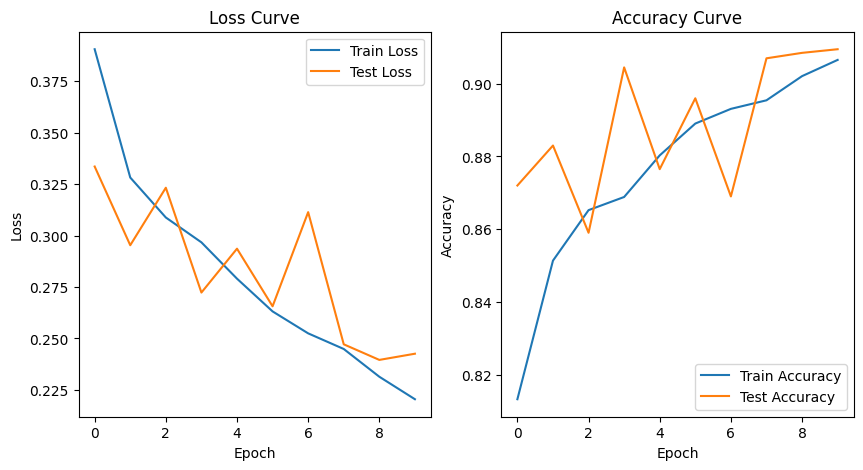

In [80]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Lo resultados no acaban de ser satisfacctorios, pese a que vemos que los datos del train aprenden rápido, como esperabamos, y llegamos en tan solo 10 iteraciones, a un valor de precisión correcto, por otro lado se observa que los resultados del conjunto de entrenamiento son muy inestables en todo momento, y incluso en muchos momentos parecen acertar de "casualidad" con más precisión que los datos de entrenamiento.

**Blanco y Negro**

Una vez hemos visto un primer modelo, donde se observan un poco los valores en torno a los que nos vamos a mover he querido probar de reducir la información (y el peso) de las imágenes y analizar que diferencias surgen en los resultados.

Al ver las imagenes, me di cuenta que muchas de ellas son muy parecidas cuando las pasamos al blanco y negro. Al final, se trata de un fondo blanco (la piel) y estamos analizando manchas oscuras, donde una de las cosas más importantes es la intensidad de esta oscuridad. En algún caso, también podemos tener pelos, pero estos son oscuros y no los vamos a perder.

Conociendo un poco más el dominio, llegamos a la conclusión que los resultados no deberían variar en exceso en casos de tener las imágenes en blanco y negro así que vamos a cargarlas como antes, pero añadiendo una linea de código que incluya la transformación de color. Es importante saber que la normalización también se verá afectada en este caso.

In [4]:
# Carga de datos con tranformación a blanco y negro

transform_bw = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.Grayscale(),       # Convierte las imágenes a escala de grises
    transforms.ToTensor(),         
    transforms.Normalize((0.5,), (0.5,))  
])

# Rutas de las carpetas de entrenamiento y prueba
train_path_bw = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path_bw = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset_bw = datasets.ImageFolder(root=train_path_bw, transform=transform_bw)

# Cargar conjunto de datos de prueba
test_dataset_bw = datasets.ImageFolder(root=test_path_bw, transform=transform_bw)

# Crear iteradores de carga de datos
train_loader_bw = torch.utils.data.DataLoader(train_dataset_bw, batch_size=64, shuffle=True)
test_loader_bw = torch.utils.data.DataLoader(test_dataset_bw, batch_size=64, shuffle=False)


Al visualizar, ya no podemos usar numpy, ya que es lo primero que prové y me aparecían las imágenes en azul y verde. Se hace de la forma siguiente

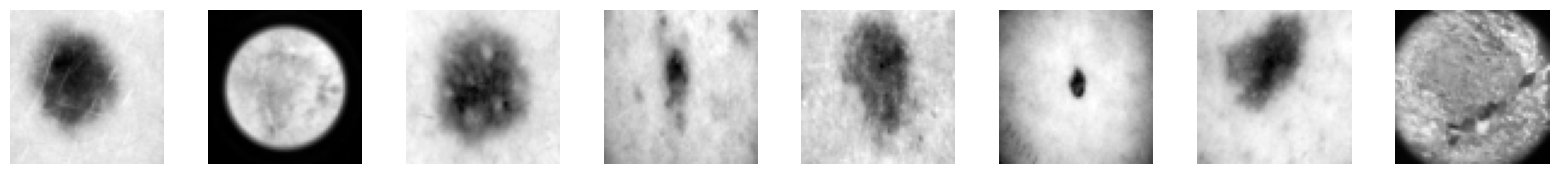

In [5]:
# Visualización Blanco y Negro

# Obtener un lote de imágenes de entrenamiento
images, labels = next(iter(train_loader_bw))

# Mostrar las primeras 8 imágenes del lote
fig, axes = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')  # Mostrar la imagen en escala de grises
    ax.axis('off')
plt.show()

Aunque ya lo sabemos, a continuación también calcularemos el tamaño en píxeles de las imágenes y, muy importante en este caso, la cantidad de canales. El estar en blanco y negro, ahora solo tenemos un canal, que es donde estamos reduciendo la información (y el peso) de estas.

In [6]:
# Tamaño en píxeles y número de canales de las imágenes en blanco y negro
print("Tamaño en píxeles y número de canales de las imágenes en blanco y negro:")
for i, (images, _) in enumerate(train_loader_bw):
    batch_size, channels, height, width = images.shape
    print(f"Tamaño de las imágenes en el lote {i+1}: {width}x{height} píxeles, {channels} canal(es)")
    break  # Solo imprimimos información sobre el primer lote


Tamaño en píxeles y número de canales de las imágenes en blanco y negro:
Tamaño de las imágenes en el lote 1: 64x64 píxeles, 1 canal(es)


Una vez hemos cargado los datos, tiene todo el sentido del mundo hacer dos modelos muy similares, con todos los parámetros iguales para poder comparar los resutaldos de una forma justa. 

El unico cambio que tenemos que hacer es en la infraestructura, ya que es importante incluir que ahora solo usamos un canal.

In [9]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 96)
        self.fc2 = nn.Linear(96, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/10], Train Loss: 0.5049, Test Loss: 0.4735, Train Accuracy: 0.7570, Test Accuracy: 0.7415
Epoch [2/10], Train Loss: 0.4242, Test Loss: 0.4367, Train Accuracy: 0.7915, Test Accuracy: 0.7630
Epoch [3/10], Train Loss: 0.4027, Test Loss: 0.3726, Train Accuracy: 0.8081, Test Accuracy: 0.8295
Epoch [4/10], Train Loss: 0.3822, Test Loss: 0.3662, Train Accuracy: 0.8199, Test Accuracy: 0.8290
Epoch [5/10], Train Loss: 0.3603, Test Loss: 0.3365, Train Accuracy: 0.8328, Test Accuracy: 0.8435
Epoch [6/10], Train Loss: 0.3492, Test Loss: 0.3561, Train Accuracy: 0.8411, Test Accuracy: 0.8240
Epoch [7/10], Train Loss: 0.3311, Test Loss: 0.3497, Train Accuracy: 0.8505, Test Accuracy: 0.8290
Epoch [8/10], Train Loss: 0.3172, Test Loss: 0.3237, Train Accuracy: 0.8573, Test Accuracy: 0.8535
Epoch [9/10], Train Loss: 0.3079, Test Loss: 0.3592, Train Accuracy: 0.8630, Test Accuracy: 0.8215
Epoch [10/10], Train Loss: 0.2909, Test Loss: 0.3593, Train Accuracy: 0.8735, Test Accuracy: 0.8270


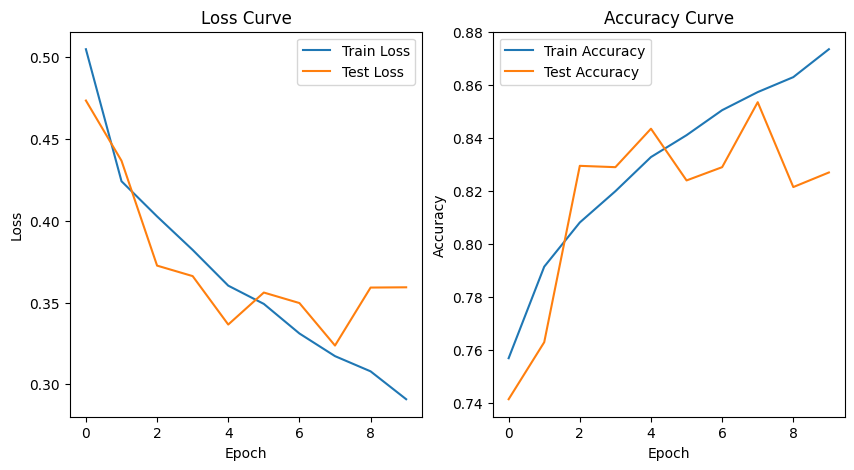

In [11]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader_bw, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader_bw:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader_bw))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Epoch [1/100], Train Loss: 0.8087, Test Loss: 0.5372, Train Accuracy: 0.6575, Test Accuracy: 0.7025
Epoch [2/100], Train Loss: 0.4713, Test Loss: 0.4868, Train Accuracy: 0.7602, Test Accuracy: 0.7395
Epoch [3/100], Train Loss: 0.4414, Test Loss: 0.4563, Train Accuracy: 0.7842, Test Accuracy: 0.7620
Epoch [4/100], Train Loss: 0.4275, Test Loss: 0.4897, Train Accuracy: 0.7923, Test Accuracy: 0.7260
Epoch [5/100], Train Loss: 0.4166, Test Loss: 0.4552, Train Accuracy: 0.7964, Test Accuracy: 0.7460
Epoch [6/100], Train Loss: 0.4068, Test Loss: 0.4431, Train Accuracy: 0.8050, Test Accuracy: 0.7630
Epoch [7/100], Train Loss: 0.4020, Test Loss: 0.4305, Train Accuracy: 0.8080, Test Accuracy: 0.7790
Epoch [8/100], Train Loss: 0.3967, Test Loss: 0.4135, Train Accuracy: 0.8097, Test Accuracy: 0.7860
Epoch [9/100], Train Loss: 0.3915, Test Loss: 0.4259, Train Accuracy: 0.8163, Test Accuracy: 0.7755
Epoch [10/100], Train Loss: 0.3913, Test Loss: 0.3788, Train Accuracy: 0.8167, Test Accuracy: 0.8255

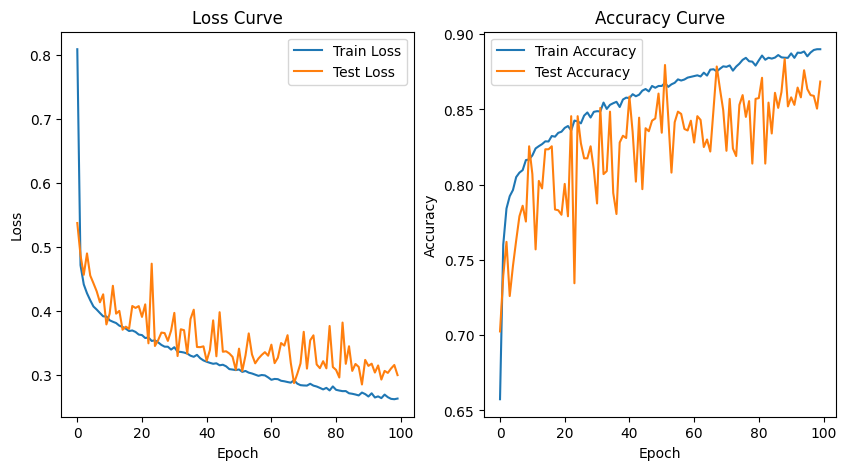

In [12]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Training loop
epochs = 100
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader_bw, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader_bw))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader_bw:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader_bw))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Como era de preveer, hemos perdido un poco de precisión en ambos modelos respecto al anterior. Es evidente que la perdida de información se ha notado, ya que tenemos alrededor de 0,05 menos capacidad de predicción. 

Si bien es verdad que en el momento que hemos dejado el modelo entrenar durante muchas iteraciones (segundo caso, learning rate de 0,0001 y 100 epoch), hemos obtenido unos resultados nada desdeñables y además, con muy poco overfitting. Si nos fijamos, pese a que seguimos con la inestabilidad en los datos de test que, por el momento no he sabido solucionar, nos ha quedado una diferencia entre datos de entrenamiento y datos de test bastante menor a la del caso anterior.

La idea de reducir los canales (eliminar los colores) era reducir el tiempo de cómputo pero, viendo los resultados del segundo modelo, no queda claro si ha llegado a su óptimo o si podría seguir mejorando. Dicho esto, parece que se podría llegar a conseguir un resultado algo mejor con más iteraciones, y esto nos haría necesitar a su vez más tiempo de cómputo, lo cuál sería contradictorio porque el objetivo era reducirlo eliminando los colores.

**Mejorar la calidad de las imágenes**

La siguiente prueba que he hecho ha sido la de aumentar la calidad de las imágenes cargadas, al hacerlo he querido ver si mejorabamos la precisión de los modelos, asumiendo que el tiempo de cómputo iba a aumentar pero buscando la máxima precisión posible.

Primero he querido aumentar estos valores a 128 píxeles. Y he creado un modelo ajustando la estrucutra de la red en relación al tamaño seleccionado.

In [2]:
# Carga de Datos

# Definir transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona las imágenes a 32x32 píxeles
    transforms.ToTensor(),         # Convierte las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes
])

# Rutas de las carpetas de entrenamiento y prueba
train_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Cargar conjunto de datos de prueba
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Crear iteradores de carga de datos
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


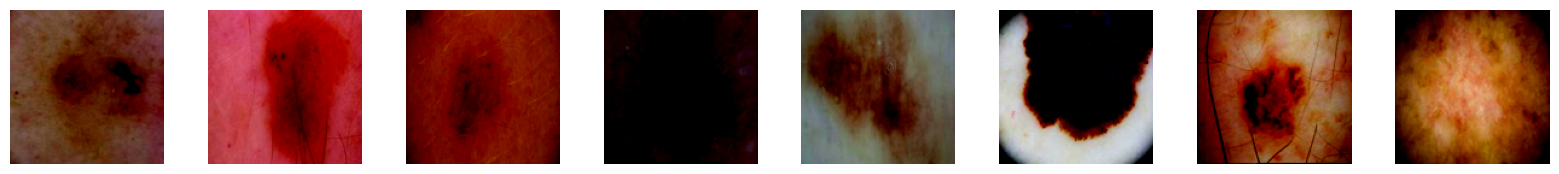

In [3]:
# Obtener un lote de imágenes de entrenamiento
images, labels = next(iter(train_loader))

# Convertir las imágenes a NumPy arrays
images = images.numpy()

# Mostrar las primeras 8 imágenes del lote
fig, axes = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Transponer las dimensiones para que sean compatibles con imshow
    ax.axis('off')
plt.show()

In [4]:
# Tamaño en píxeles y número de canales de las imágenes en blanco y negro
print("Tamaño en píxeles y número de canales de las imágenes en blanco y negro:")
for i, (images, _) in enumerate(train_loader):
    batch_size, channels, height, width = images.shape
    print(f"Tamaño de las imágenes en el lote {i+1}: {width}x{height} píxeles, {channels} canal(es)")
    break  # Solo imprimimos información sobre el primer lote


Tamaño en píxeles y número de canales de las imágenes en blanco y negro:
Tamaño de las imágenes en el lote 1: 128x128 píxeles, 3 canal(es)


In [5]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 32 * 32, 96)
        self.fc2 = nn.Linear(96, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/30], Train Loss: 0.3925, Test Loss: 0.3815, Train Accuracy: 0.8165, Test Accuracy: 0.8165
Epoch [2/30], Train Loss: 0.3176, Test Loss: 0.2919, Train Accuracy: 0.8603, Test Accuracy: 0.8875
Epoch [3/30], Train Loss: 0.2946, Test Loss: 0.2703, Train Accuracy: 0.8721, Test Accuracy: 0.9005
Epoch [4/30], Train Loss: 0.2795, Test Loss: 0.3374, Train Accuracy: 0.8804, Test Accuracy: 0.8530
Epoch [5/30], Train Loss: 0.2718, Test Loss: 0.2687, Train Accuracy: 0.8838, Test Accuracy: 0.9105
Epoch [6/30], Train Loss: 0.2555, Test Loss: 0.2759, Train Accuracy: 0.8906, Test Accuracy: 0.8905
Epoch [7/30], Train Loss: 0.2470, Test Loss: 0.2768, Train Accuracy: 0.8972, Test Accuracy: 0.8975
Epoch [8/30], Train Loss: 0.2302, Test Loss: 0.2368, Train Accuracy: 0.9038, Test Accuracy: 0.9085
Epoch [9/30], Train Loss: 0.2211, Test Loss: 0.2476, Train Accuracy: 0.9070, Test Accuracy: 0.9100
Epoch [10/30], Train Loss: 0.2086, Test Loss: 0.2676, Train Accuracy: 0.9143, Test Accuracy: 0.8950
Epoch [11

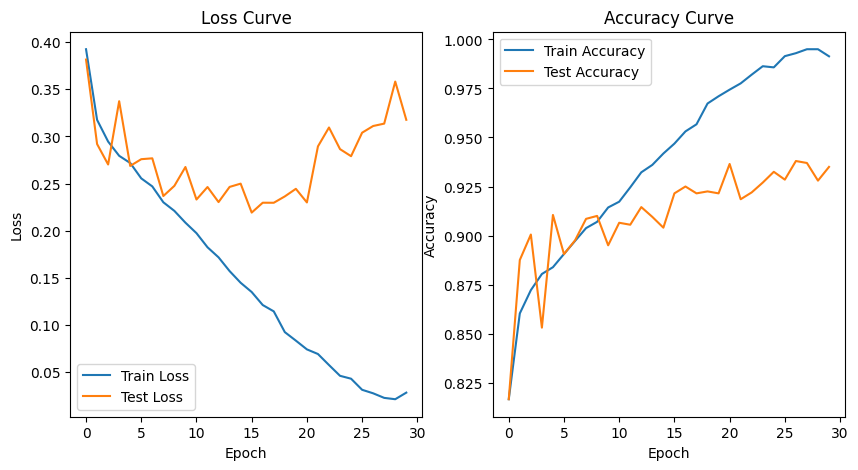

In [7]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
epochs = 30
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

El modelo creado aprende demasiado rápido, pese a que he reducido un poco el learning rate respecto a los iniciales, en tan solo 10 iteraciones ya se observa como empieza a sobreentrenarse.

Aún así, cómo es lógico, el incremento de píxeles nos ha llevado a aumentar la precisión general del modelo.

**Cambio en la arquitectura, aumento número de neuronas**

Una vez he visto que la calidad de las imágenes era lo suficientemente alta como para llegar a unos valores de precisión muy altos, he querido seguir hilando fino y ver hasta donde podíamos llegar ajustando y ajustando este modelo. Para ello, he creído que un detalle importante que no había tocado hasta ahora era el número de neuronas a incluir en nuestra red.

He pasado de 96 a 144, de esta forma, creía que la precisión mejoraría y que, con el mismo learning rate, pero la mitad de iteraciones, podríamos llegar a unos valores de precisión altos evitando el sobreentrenameinto.

In [10]:
# Aumentamos numero de neruonas
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 32 * 32, 144)
        self.fc2 = nn.Linear(144, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/30], Train Loss: 0.3791, Test Loss: 0.3806, Train Accuracy: 0.8303, Test Accuracy: 0.8285
Epoch [2/30], Train Loss: 0.3189, Test Loss: 0.3448, Train Accuracy: 0.8595, Test Accuracy: 0.8535
Epoch [3/30], Train Loss: 0.2980, Test Loss: 0.2899, Train Accuracy: 0.8704, Test Accuracy: 0.8805
Epoch [4/30], Train Loss: 0.2749, Test Loss: 0.2639, Train Accuracy: 0.8819, Test Accuracy: 0.8955
Epoch [5/30], Train Loss: 0.2563, Test Loss: 0.2943, Train Accuracy: 0.8929, Test Accuracy: 0.8780
Epoch [6/30], Train Loss: 0.2442, Test Loss: 0.2490, Train Accuracy: 0.8982, Test Accuracy: 0.9060
Epoch [7/30], Train Loss: 0.2231, Test Loss: 0.2295, Train Accuracy: 0.9068, Test Accuracy: 0.9200
Epoch [8/30], Train Loss: 0.2088, Test Loss: 0.2910, Train Accuracy: 0.9105, Test Accuracy: 0.8760
Epoch [9/30], Train Loss: 0.1918, Test Loss: 0.2602, Train Accuracy: 0.9211, Test Accuracy: 0.8905
Epoch [10/30], Train Loss: 0.1741, Test Loss: 0.2184, Train Accuracy: 0.9290, Test Accuracy: 0.9185
Epoch [11

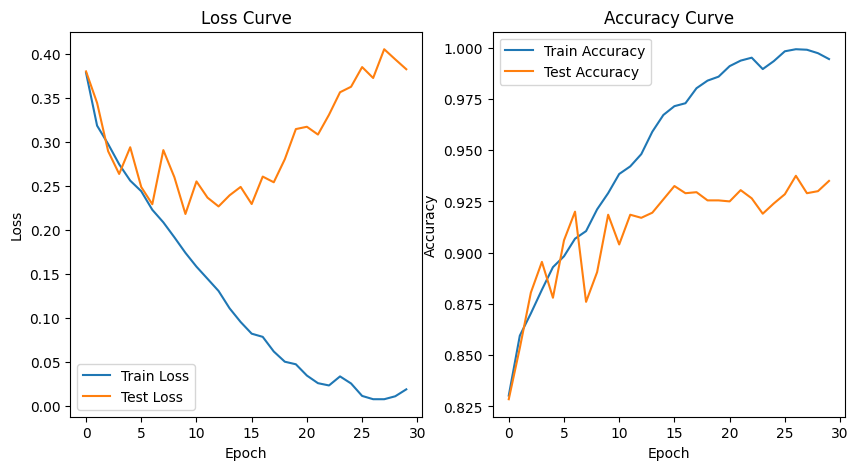

In [11]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
epochs = 30
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Como se puede observar, los resultados no han sido los esperados, en tan solo 10 iteraciones, el modelo ya se estaba sobreentrenando. Se observa una barrera alrededor del 0.93 difícil de cruzar. Y aunque los valores de entrenamiento vuelven a ser altísimos, no parece que tenga sentido la inversión en entrenamiento ya que es un modelo claramente overfitted.

¿Tendría sentido reducir un orden de magnitud para conseguir entrenar más lento y no sobreentrenar? Veamoslo:

Epoch [1/60], Train Loss: 0.4241, Test Loss: 0.3593, Train Accuracy: 0.8025, Test Accuracy: 0.8550
Epoch [2/60], Train Loss: 0.3573, Test Loss: 0.4228, Train Accuracy: 0.8418, Test Accuracy: 0.7910
Epoch [3/60], Train Loss: 0.3456, Test Loss: 0.3353, Train Accuracy: 0.8469, Test Accuracy: 0.8545
Epoch [4/60], Train Loss: 0.3328, Test Loss: 0.3366, Train Accuracy: 0.8545, Test Accuracy: 0.8565
Epoch [5/60], Train Loss: 0.3264, Test Loss: 0.3428, Train Accuracy: 0.8580, Test Accuracy: 0.8460
Epoch [6/60], Train Loss: 0.3201, Test Loss: 0.3366, Train Accuracy: 0.8618, Test Accuracy: 0.8515
Epoch [7/60], Train Loss: 0.3126, Test Loss: 0.3205, Train Accuracy: 0.8630, Test Accuracy: 0.8645
Epoch [8/60], Train Loss: 0.3056, Test Loss: 0.3063, Train Accuracy: 0.8696, Test Accuracy: 0.8775
Epoch [9/60], Train Loss: 0.3013, Test Loss: 0.3184, Train Accuracy: 0.8717, Test Accuracy: 0.8675
Epoch [10/60], Train Loss: 0.2945, Test Loss: 0.3258, Train Accuracy: 0.8753, Test Accuracy: 0.8580
Epoch [11

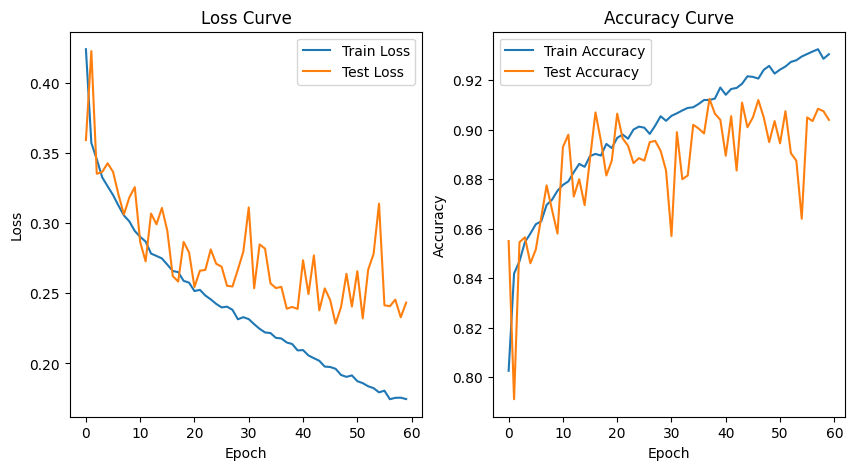

In [13]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005)

# Training loop
epochs = 60
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Pues no lo parece, puede que con un learning rate tan bajo nos hayamos quedado un poco cortos de iteraciones y es por eso que no podemos hacer un análisis preciso (error) pero las precisiones son bastante más bajas, de hecho, estamos cerca de valores que hemos visto antes con menos neuronas y imágenes de menor calidad. Vemos además que los valores del conjunto de test parecen empezar a estabilizarse a partir de las 40 operaciones alrededor del 0.90 así que podría incluso ser que nos quedaramos allí y a continuación empezara a sobreentrenarse.

El siguiente intento va a ser probar de usar imágenes menos pesadas (de solo 1 canales) pero con un tamaño mucho mayor. En este caso la idea es 256 píxeles, la máxima calidad usada para este trabajo. Queremos ver si la precisión de estos resultados seguirá siendo buena si cargamos todos estos píxeles eliminando los colores de las imágenes.

In [16]:
# Carga de datos con tranformación a blanco y negro

# Definir transformaciones para preprocesar las imágenes en blanco y negro
transform_bw_high = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona las imágenes a 64x64 píxeles
    transforms.Grayscale(),       # Convierte las imágenes a escala de grises
    transforms.ToTensor(),         # Convierte las imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normaliza las imágenes en escala de grises
])

# Rutas de las carpetas de entrenamiento y prueba
train_path_bw_high = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path_bw_high = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset_bw_high = datasets.ImageFolder(root=train_path_bw_high, transform=transform_bw_high)

# Cargar conjunto de datos de prueba
test_dataset_bw_high = datasets.ImageFolder(root=test_path_bw_high, transform=transform_bw_high)

# Crear iteradores de carga de datos
train_loader_bw_high = torch.utils.data.DataLoader(train_dataset_bw_high, batch_size=64, shuffle=True)
test_loader_bw_high = torch.utils.data.DataLoader(test_dataset_bw_high, batch_size=64, shuffle=False)

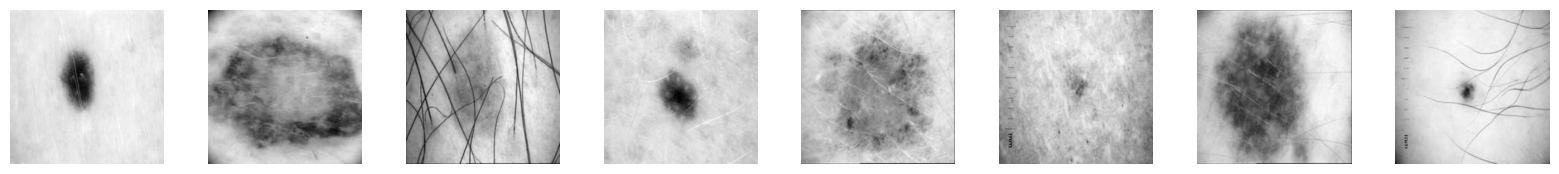

In [19]:
# Visualización Blanco y Negro

# Obtener un lote de imágenes de entrenamiento
images, labels = next(iter(train_loader_bw_high))

# Mostrar las primeras 8 imágenes del lote
fig, axes = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')  # Mostrar la imagen en escala de grises
    ax.axis('off')
plt.show()

In [22]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 64 * 64, 144)
        self.fc2 = nn.Linear(144, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 64 * 64)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/20], Train Loss: 0.4533, Test Loss: 0.4477, Train Accuracy: 0.7699, Test Accuracy: 0.7530
Epoch [2/20], Train Loss: 0.4053, Test Loss: 0.3927, Train Accuracy: 0.8019, Test Accuracy: 0.8075
Epoch [3/20], Train Loss: 0.3808, Test Loss: 0.3809, Train Accuracy: 0.8239, Test Accuracy: 0.8105
Epoch [4/20], Train Loss: 0.3551, Test Loss: 0.3791, Train Accuracy: 0.8386, Test Accuracy: 0.8125
Epoch [5/20], Train Loss: 0.3385, Test Loss: 0.3831, Train Accuracy: 0.8459, Test Accuracy: 0.7975
Epoch [6/20], Train Loss: 0.3209, Test Loss: 0.3602, Train Accuracy: 0.8598, Test Accuracy: 0.8160
Epoch [7/20], Train Loss: 0.3087, Test Loss: 0.3319, Train Accuracy: 0.8639, Test Accuracy: 0.8465
Epoch [8/20], Train Loss: 0.2927, Test Loss: 0.3054, Train Accuracy: 0.8740, Test Accuracy: 0.8630
Epoch [9/20], Train Loss: 0.2808, Test Loss: 0.2930, Train Accuracy: 0.8784, Test Accuracy: 0.8645
Epoch [10/20], Train Loss: 0.2713, Test Loss: 0.2942, Train Accuracy: 0.8840, Test Accuracy: 0.8705
Epoch [11

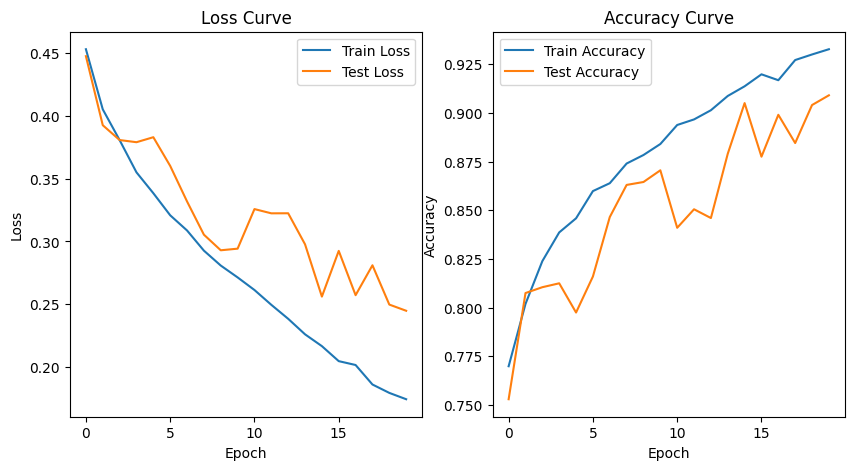

In [25]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Training loop
epochs = 20
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader_bw_high, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader_bw_high))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader_bw_high:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader_bw_high))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [26]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 9438866


Al hacerlo, vemos que queda un modelo que no esta nada mal, los resultados de test y train van bastante a la par y, aunque si que acabamos con un poco de diferencia entre los dos conjuntos de datos, no parece que aún se este sobreeentrenando de una manera excesiva. 

De todas formas, y por primera vez en todo el trabajo, al finalizar este modelo decidí mirar la cantidad de parámetros que estabamos usando para este modelo, al hacerlo, pensaba que obtendría unos valores cercanos a la limitación que tenemos, pero para nada. Hasta ahora he estado trabajando con fuerza bruta, intentando hacerlo todo con muchas neuronas y un tiempo y capacidad de cómputo excesivo, la mayoría de los modelos podían estar entre 60 y 90 minutos entrenando.

En definitiva, estábamos matando moscas a cañonazos, así que a partir del siguiente modelo, vamos a intentar obtener los mejores resultados posibles pensando un poco más, y sobretodo, siendo más eficiente con los recursos.

# Optimización de Parámetros

**Reducción de calidad, blanco y negro, pocas iteraciones y bajo learning rate**

Una vez aprendida la lección, vamos a empezar a hacer los modelos más simples posibles, buscando mínimizar al máximo el número de parámetros y buscar entender en que valores nos podemos mover. La primera opción será cargar imágenes de baja calidad y tamaño, de solo un canal y buscar una red neuronal de tan solo 24 neuronas.

In [27]:
# Carga de datos con tranformación a blanco y negro

# Definir transformaciones para preprocesar las imágenes en blanco y negro
transform_bw_low = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensiona las imágenes a 64x64 píxeles
    transforms.Grayscale(),       # Convierte las imágenes a escala de grises
    transforms.ToTensor(),         # Convierte las imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normaliza las imágenes en escala de grises
])

# Rutas de las carpetas de entrenamiento y prueba
train_path_bw_low = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path_bw_low = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset_bw_low = datasets.ImageFolder(root=train_path_bw_low, transform=transform_bw_low)

# Cargar conjunto de datos de prueba
test_dataset_bw_low = datasets.ImageFolder(root=test_path_bw_low, transform=transform_bw_low)

# Crear iteradores de carga de datos
train_loader_bw_low = torch.utils.data.DataLoader(train_dataset_bw_low, batch_size=64, shuffle=True)
test_loader_bw_low = torch.utils.data.DataLoader(test_dataset_bw_low, batch_size=64, shuffle=False)

In [30]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 8 * 8, 24)
        self.fc2 = nn.Linear(24, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/10], Train Loss: 0.6213, Test Loss: 0.5655, Train Accuracy: 0.6539, Test Accuracy: 0.6980
Epoch [2/10], Train Loss: 0.5113, Test Loss: 0.4981, Train Accuracy: 0.7310, Test Accuracy: 0.7370
Epoch [3/10], Train Loss: 0.4704, Test Loss: 0.5024, Train Accuracy: 0.7569, Test Accuracy: 0.7105
Epoch [4/10], Train Loss: 0.4520, Test Loss: 0.5061, Train Accuracy: 0.7715, Test Accuracy: 0.7120
Epoch [5/10], Train Loss: 0.4411, Test Loss: 0.4806, Train Accuracy: 0.7831, Test Accuracy: 0.7335
Epoch [6/10], Train Loss: 0.4352, Test Loss: 0.4554, Train Accuracy: 0.7861, Test Accuracy: 0.7535
Epoch [7/10], Train Loss: 0.4296, Test Loss: 0.4431, Train Accuracy: 0.7913, Test Accuracy: 0.7615
Epoch [8/10], Train Loss: 0.4252, Test Loss: 0.4709, Train Accuracy: 0.7944, Test Accuracy: 0.7345
Epoch [9/10], Train Loss: 0.4216, Test Loss: 0.4751, Train Accuracy: 0.7963, Test Accuracy: 0.7240
Epoch [10/10], Train Loss: 0.4162, Test Loss: 0.4598, Train Accuracy: 0.7985, Test Accuracy: 0.7410


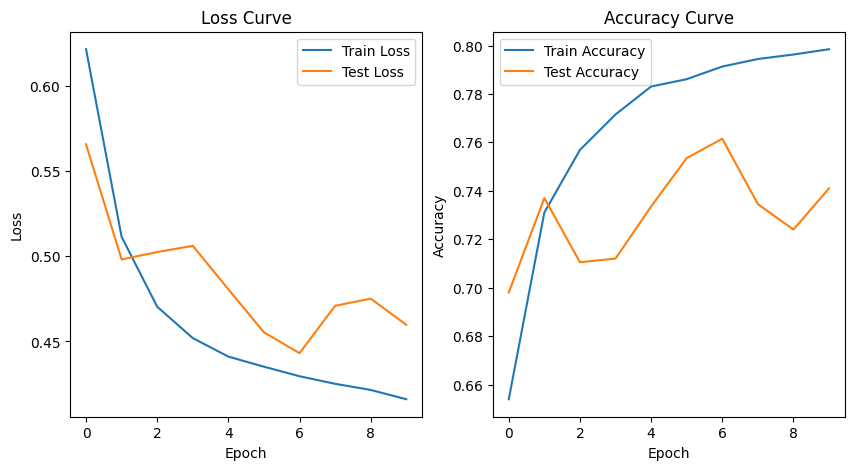

In [31]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Training loop
epochs = 10
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader_bw_low, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader_bw_low))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader_bw_low:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader_bw_low))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [32]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 25898


Como era de preveer, este primer modelo es bastante flojo, si bien es cierto que es el tiempo de cómputo más bajo que hemos tenido en todos los modelos, 4 minutos y medio y lo tenemos entrenado, la precisión es bastante baja y además, parece empezar a sobreentrenarse muy pronto.

Por otro lado, calculando la cantidad de parámetros vemos que es un valor base muy inferior a nuestra limitación, así que tenemos margen y podemos aumentar bastante la complejidad de la arquitectura para mejorar la precisión.

**Mejora en la cálidad de las imágenes**

In [35]:
# Carga de datos con tranformación a blanco y negro

# Definir transformaciones para preprocesar las imágenes en blanco y negro
transform_bw_mid = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.Grayscale(),       
    transforms.ToTensor(),       
    transforms.Normalize((0.5,), (0.5,))  
])

# Rutas de las carpetas de entrenamiento y prueba
train_path_bw_mid = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path_bw_mid = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset_bw_mid = datasets.ImageFolder(root=train_path_bw_mid, transform=transform_bw_mid)

# Cargar conjunto de datos de prueba
test_dataset_bw_mid = datasets.ImageFolder(root=test_path_bw_mid, transform=transform_bw_mid)

# Crear iteradores de carga de datos
train_loader_bw_mid = torch.utils.data.DataLoader(train_dataset_bw_mid, batch_size=64, shuffle=True)
test_loader_bw_mid = torch.utils.data.DataLoader(test_dataset_bw_mid, batch_size=64, shuffle=False)

In [36]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 24)
        self.fc2 = nn.Linear(24, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


Epoch [1/10], Train Loss: 0.5513, Test Loss: 0.5227, Train Accuracy: 0.6921, Test Accuracy: 0.7125
Epoch [2/10], Train Loss: 0.4623, Test Loss: 0.5056, Train Accuracy: 0.7600, Test Accuracy: 0.7365
Epoch [3/10], Train Loss: 0.4382, Test Loss: 0.4769, Train Accuracy: 0.7840, Test Accuracy: 0.7465
Epoch [4/10], Train Loss: 0.4246, Test Loss: 0.4561, Train Accuracy: 0.7922, Test Accuracy: 0.7625
Epoch [5/10], Train Loss: 0.4170, Test Loss: 0.4416, Train Accuracy: 0.7959, Test Accuracy: 0.7685
Epoch [6/10], Train Loss: 0.4091, Test Loss: 0.4260, Train Accuracy: 0.8030, Test Accuracy: 0.7800
Epoch [7/10], Train Loss: 0.4016, Test Loss: 0.4358, Train Accuracy: 0.8071, Test Accuracy: 0.7715
Epoch [8/10], Train Loss: 0.3963, Test Loss: 0.4207, Train Accuracy: 0.8108, Test Accuracy: 0.7865
Epoch [9/10], Train Loss: 0.3914, Test Loss: 0.3973, Train Accuracy: 0.8137, Test Accuracy: 0.8070
Epoch [10/10], Train Loss: 0.3866, Test Loss: 0.3995, Train Accuracy: 0.8195, Test Accuracy: 0.8055


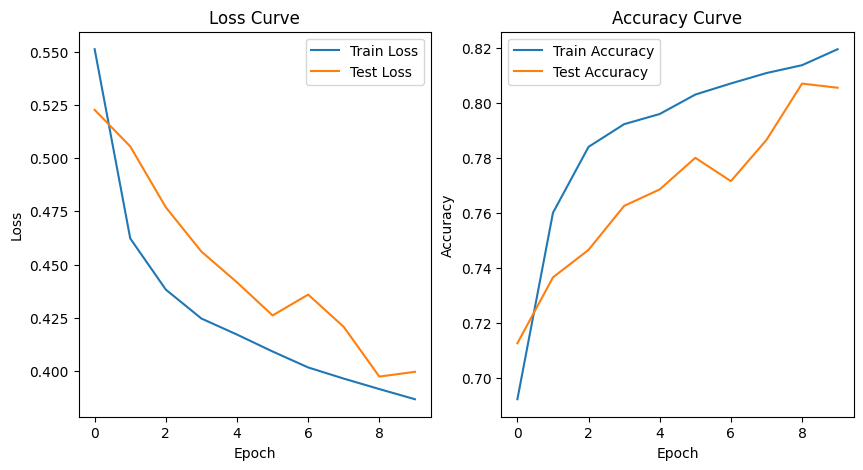

In [37]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Training loop
epochs = 10
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader_bw_mid, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader_bw_mid))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader_bw_mid:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader_bw_mid))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [38]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 99626


Con el aumento del tamaño de las imagenes de 32x32 a 64x64 píxeles, obtenemos un modelo que sigue lejos de las precisiones vistas anteriormente, pero que con una arquitectura muy similar, obtiene unos resultados notablemente mejores tanto en precisión como en robustez. La diferencia entre test y train en este caso es muy pequeña, y la precisión es también un 0.6 mayor.

También es importante observar que el tiempo de cómputo sigue siendo muy pequeño en comparación con los modelos de fuerza bruta, en tan solo 5 minutos tenemos este modelo entrenado.

Por otro lado, el número de parámetros aumenta considerablemente, pese a que el pooling reduce dos veces a la mitad el tamaño de las imágenes, las resultantes siguen siendo el doble de grandes que las del modelo anterior, y esto hace que usemos muchos más parámetros. 

Aún así, seguimos lejos del máximo, así que podemos seguir añadiendo información y complejidad a nuestro modelo.

**Añadimos color a las imágenes**

El siguiente paso, antes de empezar a modificar la infraestructura "perse" va a ser seguir añadiendo información, seguir mejorando las imágenes para aumentar la precisión. En este caso, vamos a seguir con imagenes de 64x64 píxeles, pero ahora, con 3 canales, es decir, en color.

Como se esperan unos resultados mejores a los anteriores, he decidido probar dos modelos, uno con 10 epoch y el siguiente con 30, de esta manera veremos las diferencias entre ellos y si se llega a sobreentrenar o si simplemente obtenemos mejores resultados.

In [39]:
# Carga de Datos

# Definir transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensiona las imágenes a 64x64 píxeles
    transforms.ToTensor(),         # Convierte las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes
])

# Rutas de las carpetas de entrenamiento y prueba
train_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Cargar conjunto de datos de prueba
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Crear iteradores de carga de datos
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [42]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 24)
        self.fc2 = nn.Linear(24, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/10], Train Loss: 0.5049, Test Loss: 0.4433, Train Accuracy: 0.7418, Test Accuracy: 0.7825
Epoch [2/10], Train Loss: 0.4007, Test Loss: 0.3997, Train Accuracy: 0.8153, Test Accuracy: 0.8020
Epoch [3/10], Train Loss: 0.3726, Test Loss: 0.3908, Train Accuracy: 0.8345, Test Accuracy: 0.8065
Epoch [4/10], Train Loss: 0.3547, Test Loss: 0.3623, Train Accuracy: 0.8435, Test Accuracy: 0.8360
Epoch [5/10], Train Loss: 0.3469, Test Loss: 0.3558, Train Accuracy: 0.8464, Test Accuracy: 0.8400
Epoch [6/10], Train Loss: 0.3380, Test Loss: 0.4032, Train Accuracy: 0.8502, Test Accuracy: 0.8020
Epoch [7/10], Train Loss: 0.3371, Test Loss: 0.3449, Train Accuracy: 0.8515, Test Accuracy: 0.8460
Epoch [8/10], Train Loss: 0.3325, Test Loss: 0.3315, Train Accuracy: 0.8511, Test Accuracy: 0.8570
Epoch [9/10], Train Loss: 0.3303, Test Loss: 0.3561, Train Accuracy: 0.8544, Test Accuracy: 0.8330
Epoch [10/10], Train Loss: 0.3259, Test Loss: 0.3165, Train Accuracy: 0.8564, Test Accuracy: 0.8700


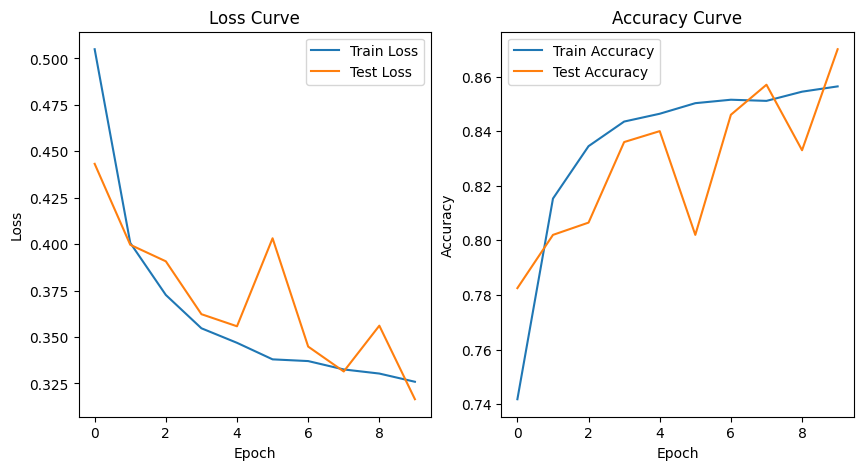

In [44]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Training loop
epochs = 10
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [45]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 99770


**Mantenemos arquitectura pero aumentamos Epochs**

Epoch [1/30], Train Loss: 0.5254, Test Loss: 0.4410, Train Accuracy: 0.7244, Test Accuracy: 0.7810
Epoch [2/30], Train Loss: 0.3874, Test Loss: 0.3774, Train Accuracy: 0.8273, Test Accuracy: 0.8305
Epoch [3/30], Train Loss: 0.3677, Test Loss: 0.3564, Train Accuracy: 0.8353, Test Accuracy: 0.8440
Epoch [4/30], Train Loss: 0.3546, Test Loss: 0.3627, Train Accuracy: 0.8419, Test Accuracy: 0.8330
Epoch [5/30], Train Loss: 0.3497, Test Loss: 0.3498, Train Accuracy: 0.8429, Test Accuracy: 0.8410
Epoch [6/30], Train Loss: 0.3456, Test Loss: 0.3399, Train Accuracy: 0.8449, Test Accuracy: 0.8595
Epoch [7/30], Train Loss: 0.3378, Test Loss: 0.3566, Train Accuracy: 0.8487, Test Accuracy: 0.8340
Epoch [8/30], Train Loss: 0.3316, Test Loss: 0.3719, Train Accuracy: 0.8514, Test Accuracy: 0.8230
Epoch [9/30], Train Loss: 0.3267, Test Loss: 0.3366, Train Accuracy: 0.8544, Test Accuracy: 0.8505
Epoch [10/30], Train Loss: 0.3237, Test Loss: 0.3303, Train Accuracy: 0.8566, Test Accuracy: 0.8585
Epoch [11

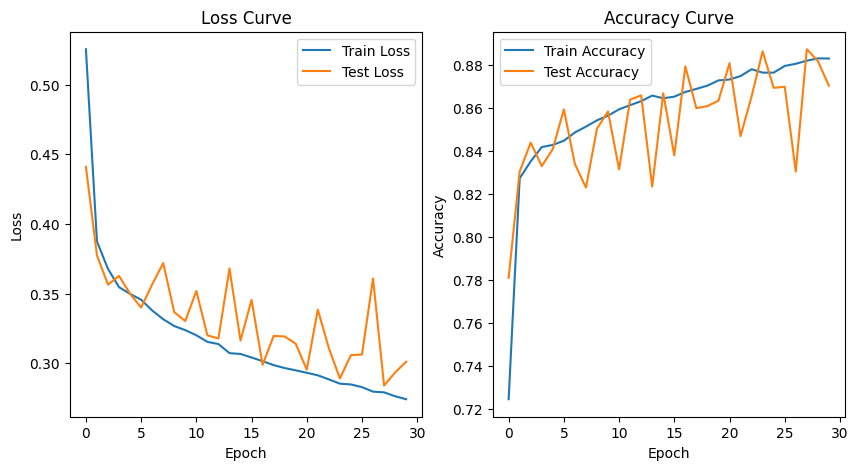

In [46]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Training loop
epochs = 30
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [47]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 99770


Definitivamente, ha sido una buena decisión aumentar el número de Epochs, ya que nos estábamos quedando cortos con tan solo 10. Los resultados siguen siendo bastante positivos,  de hecho, en las últimas iteraciones del modelo rondamos el 0.88 que ya empiezan a ser valores muy cercanos a los vistos anteriormente en modelos mucho más costosos.

Es importante mencionar que en este caso, los resultados del conjunto de validación son muy inestables y realmente tienen picos y valles muy pronunciados. Sin embargo,  si parecen seguir una tendencia ascendente, es decir, aún no se habían estancado en un valor concreto y la tendencia es bastante similar a la de los resultados del conjunto de prueba.

Por otro lado, también vemos que conforme vamos añadiendo información (y peso) de las imágenes, vamos aumentando el tiempo de cómputo, que para el modelo de 10 iteraciones, está ya un poco por encima de los 6 minutos, y en el caso del de 30, de los 18.

Por último, el número de parámetros. En este caso, el valor de parámetros utilizado ha crecido muy poco, estamos tan solo en 100000, así que parece que seguimos teniendo margen para mejorar el modelo.

**Aumentamos neuronas y learning rate**

Lo dicho, como tenemos margen, vamos a aumentar el número de neuronas, y manteniendo el tamaño de las imágenes, reducir el learning rate. Quiero ver si con un modelo "más inteligente" podemos obtener mejores resultados aprendiendo más "poco a poco".

In [48]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 48)
        self.fc2 = nn.Linear(48, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/30], Train Loss: 0.3948, Test Loss: 0.3788, Train Accuracy: 0.8145, Test Accuracy: 0.8220
Epoch [2/30], Train Loss: 0.3399, Test Loss: 0.3180, Train Accuracy: 0.8492, Test Accuracy: 0.8740
Epoch [3/30], Train Loss: 0.3215, Test Loss: 0.3371, Train Accuracy: 0.8605, Test Accuracy: 0.8475
Epoch [4/30], Train Loss: 0.3055, Test Loss: 0.3189, Train Accuracy: 0.8690, Test Accuracy: 0.8630
Epoch [5/30], Train Loss: 0.2925, Test Loss: 0.2747, Train Accuracy: 0.8750, Test Accuracy: 0.9020
Epoch [6/30], Train Loss: 0.2868, Test Loss: 0.2930, Train Accuracy: 0.8763, Test Accuracy: 0.8950
Epoch [7/30], Train Loss: 0.2833, Test Loss: 0.2585, Train Accuracy: 0.8778, Test Accuracy: 0.9090
Epoch [8/30], Train Loss: 0.2736, Test Loss: 0.2639, Train Accuracy: 0.8821, Test Accuracy: 0.9015
Epoch [9/30], Train Loss: 0.2665, Test Loss: 0.2578, Train Accuracy: 0.8874, Test Accuracy: 0.9060
Epoch [10/30], Train Loss: 0.2617, Test Loss: 0.2895, Train Accuracy: 0.8881, Test Accuracy: 0.8825
Epoch [11

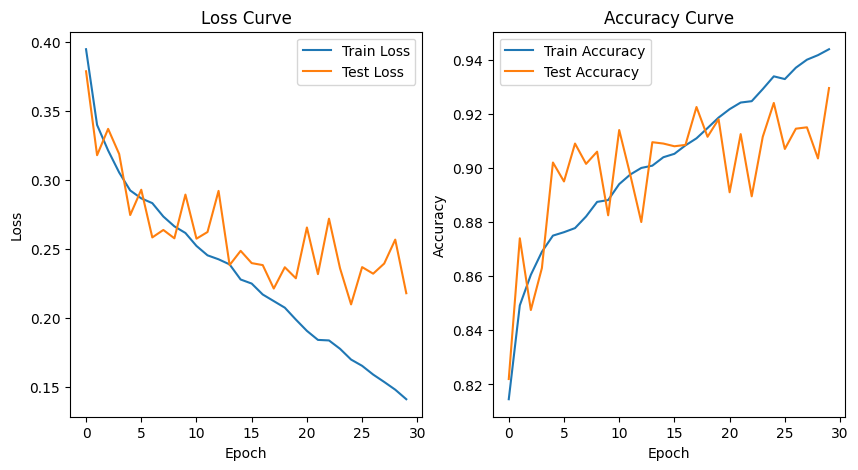

In [49]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
epochs = 30
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [50]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 198146


Seguimos mejorando los resultados y la verdad es que es curioso como vamos viendo que cada vez estamos más cerca de los valores obtenidos con modelos muchisimo más complejos al inicio de este trabajo, modelos que tardaban 5 veces más en entrenarse y que podían usar 10 veces más parámetros.

En este caso, pese a que seguimos con mucha inestabilidad en los resultados de validación, vemos que siguen subiendo hasta una precisión que es estabilizan alrededor de 0.90. Si bien es cierto que en las últimas 10 iteraciones parece que la diferencia de resultados entre conjuntos parece aumentar, deberíamos verlo con más iteraciones para confirmar que estamos sobreentrenando.

El tiempo de cómputo sigue siendo correcto, de hecho, estamos un minuto por debajo del tiempo de cómputo del modelo anterior. Y, por último, lo que si que crece de una forma importante son los parámetros utilizados. En este modelo usamos casi 200000 parámetros. La valoración de este modelo puede ser positiva ya que estamos por debajo del límite que nos han puesto, pero es verdad que en según que circumstancia, podría no interesarnos duplicar el número de parámetros a cambio de una mejora de tan solo 0.02 de precisión.

**Aumentamos Epochs**

Como comentaba, parece que se esta empezando a sobreentrenar a partir de la iteracion número 20, así que he querido probar de ver si esto era cierto aumentando el número de epoch a 50 y observando los resultados.

Epoch [1/50], Train Loss: 0.4012, Test Loss: 0.4310, Train Accuracy: 0.8073, Test Accuracy: 0.7815
Epoch [2/50], Train Loss: 0.3445, Test Loss: 0.3690, Train Accuracy: 0.8452, Test Accuracy: 0.8175
Epoch [3/50], Train Loss: 0.3272, Test Loss: 0.2996, Train Accuracy: 0.8526, Test Accuracy: 0.8830
Epoch [4/50], Train Loss: 0.3124, Test Loss: 0.3063, Train Accuracy: 0.8621, Test Accuracy: 0.8730
Epoch [5/50], Train Loss: 0.3016, Test Loss: 0.3458, Train Accuracy: 0.8681, Test Accuracy: 0.8395
Epoch [6/50], Train Loss: 0.2965, Test Loss: 0.3104, Train Accuracy: 0.8697, Test Accuracy: 0.8680
Epoch [7/50], Train Loss: 0.2882, Test Loss: 0.2749, Train Accuracy: 0.8741, Test Accuracy: 0.8955
Epoch [8/50], Train Loss: 0.2800, Test Loss: 0.2637, Train Accuracy: 0.8784, Test Accuracy: 0.9050
Epoch [9/50], Train Loss: 0.2706, Test Loss: 0.3153, Train Accuracy: 0.8829, Test Accuracy: 0.8640
Epoch [10/50], Train Loss: 0.2614, Test Loss: 0.3455, Train Accuracy: 0.8897, Test Accuracy: 0.8420
Epoch [11

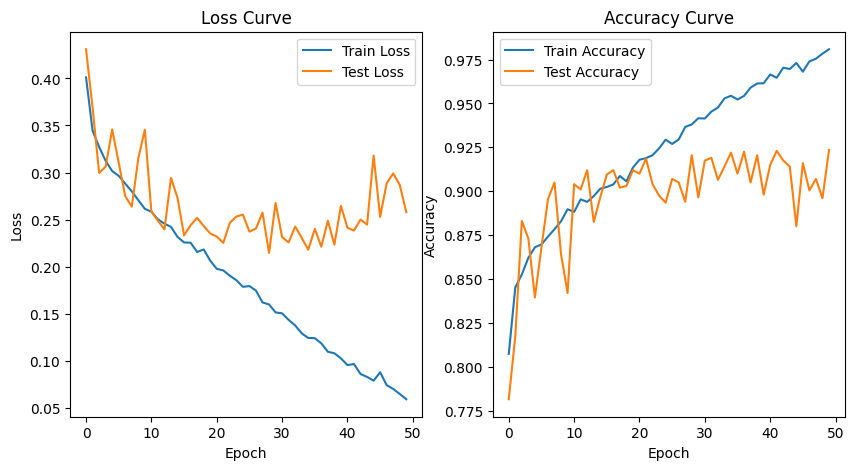

In [51]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
epochs = 50
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [52]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 198146


¡Se confirma nuestra hipótesis!

Como vemos en ambos gráficos, a partir de los 20 epoch, los resultados de validación se estabilizan alrededor de 0.90-0.92 y los de prueba parecen aprenderse el dataset de memoria para llegar a precisiones altísimas. Era mucho mejor el modelo anterior, ya que no se sobreentrenaba y tardaba 11 minutos menos en entrenar.

**Aumentamos neuronas y learning rate**

Viendo que seguimos teniendo margen de mejora, he querido aumentar el número de neuronas, buscando llegar al límite de los parámetros permitidos y intentar obtener un poco más de precisión. Para este modelo vamos a usar 60 neuronas.

In [53]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 60)
        self.fc2 = nn.Linear(60, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/20], Train Loss: 0.4114, Test Loss: 0.3543, Train Accuracy: 0.8117, Test Accuracy: 0.8340
Epoch [2/20], Train Loss: 0.3326, Test Loss: 0.3665, Train Accuracy: 0.8525, Test Accuracy: 0.8330
Epoch [3/20], Train Loss: 0.3181, Test Loss: 0.3076, Train Accuracy: 0.8605, Test Accuracy: 0.8690
Epoch [4/20], Train Loss: 0.3001, Test Loss: 0.3106, Train Accuracy: 0.8703, Test Accuracy: 0.8620
Epoch [5/20], Train Loss: 0.2903, Test Loss: 0.3211, Train Accuracy: 0.8759, Test Accuracy: 0.8605
Epoch [6/20], Train Loss: 0.2792, Test Loss: 0.2978, Train Accuracy: 0.8784, Test Accuracy: 0.8835
Epoch [7/20], Train Loss: 0.2696, Test Loss: 0.2958, Train Accuracy: 0.8863, Test Accuracy: 0.8750
Epoch [8/20], Train Loss: 0.2621, Test Loss: 0.2632, Train Accuracy: 0.8871, Test Accuracy: 0.9040
Epoch [9/20], Train Loss: 0.2558, Test Loss: 0.2808, Train Accuracy: 0.8897, Test Accuracy: 0.8830
Epoch [10/20], Train Loss: 0.2489, Test Loss: 0.2629, Train Accuracy: 0.8976, Test Accuracy: 0.8935
Epoch [11

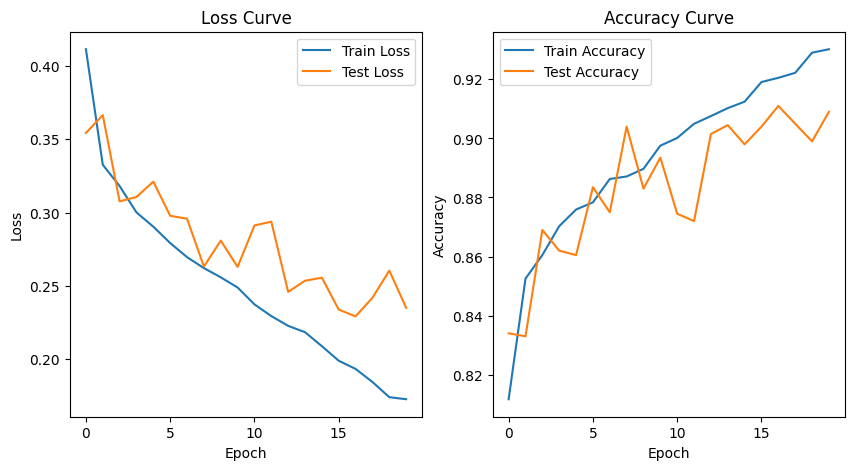

In [54]:
# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [55]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 247334


Vistos los resultados, la verdad es que nos valores que obtenemos de precisión son muy parecidos y, si bien es cierto que el learning rate era más alto y que tan solo hemos usado 20 epochs, no parece que sea un modelo mejor que alguno de los anteriores pese al aumento en el número de neuronas, y en relación a los tiempos de cómputo, está alrededor de los 17 minutos, así que tampoco es un modelo que se entrene rapidísimo.

Por último, el tema de los parámetros si que aumenta mucho, pasamos a estar usando 274334 parámetros, un poco por debajo de los máximos permitidos, pero como digo, es interesante observar que no estamos encontrando el mejor modelo cuando estamos usando la mayor cantidad de parámetros.

**Mejoramos calidad imágenes**

He querido acabar de hacer una última prueba aumentando un poco más el tamaño de las imágenes para ver si podemos observar alguna mejora superior que nos ayude a obtener mejores resultados.

In [66]:
# Carga de Datos

# Definir transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((80, 80)),  # Redimensiona las imágenes a 64x64 píxeles
    transforms.ToTensor(),         # Convierte las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza las imágenes
])

# Rutas de las carpetas de entrenamiento y prueba
train_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\train"
test_path = "C:\\Users\\Marc\\Desktop\\Master\\Inteligencia Artificial\\Deep Learning\\DL-2\\test"

# Cargar conjunto de datos de entrenamiento
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Cargar conjunto de datos de prueba
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Crear iteradores de carga de datos
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Epoch [1/20], Train Loss: 0.3873, Test Loss: 0.3305, Train Accuracy: 0.8236, Test Accuracy: 0.8830
Epoch [2/20], Train Loss: 0.3253, Test Loss: 0.3097, Train Accuracy: 0.8579, Test Accuracy: 0.8675
Epoch [3/20], Train Loss: 0.3108, Test Loss: 0.2832, Train Accuracy: 0.8664, Test Accuracy: 0.8850
Epoch [4/20], Train Loss: 0.2904, Test Loss: 0.2676, Train Accuracy: 0.8763, Test Accuracy: 0.8980
Epoch [5/20], Train Loss: 0.2857, Test Loss: 0.2688, Train Accuracy: 0.8793, Test Accuracy: 0.8920
Epoch [6/20], Train Loss: 0.2642, Test Loss: 0.2846, Train Accuracy: 0.8872, Test Accuracy: 0.8860
Epoch [7/20], Train Loss: 0.2497, Test Loss: 0.3235, Train Accuracy: 0.8923, Test Accuracy: 0.8620
Epoch [8/20], Train Loss: 0.2411, Test Loss: 0.3070, Train Accuracy: 0.8986, Test Accuracy: 0.8735
Epoch [9/20], Train Loss: 0.2305, Test Loss: 0.2418, Train Accuracy: 0.9018, Test Accuracy: 0.9125
Epoch [10/20], Train Loss: 0.2213, Test Loss: 0.2349, Train Accuracy: 0.9081, Test Accuracy: 0.9135
Epoch [11

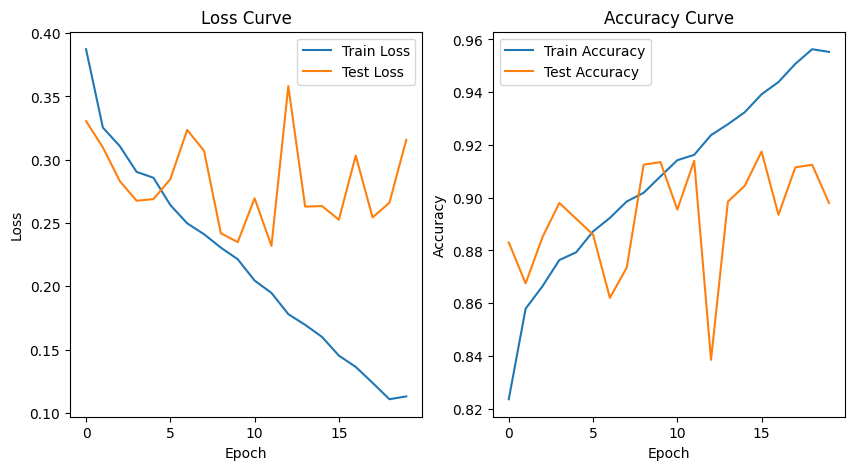

In [68]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 20 * 20, 40)
        self.fc2 = nn.Linear(40, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 20 * 20)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [69]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 257514


La realidad es que en este caso ya estamos pasados en terminos de parámetros y que es posible además que el modelo resultante se este empezando a sobreentrenar ya a partir del epoch 10. Vemos que la distancia entre los resultados de test y train es cada vez mayor y, realmente, los resultados no parecen ser exageradamente buenos.

**Cambiamos la arquitectura**

La última prueba posible ha sido intentar crear un modelo con una arquitectura algo distinta a las anteriores. Teniendo en cuenta que en el caso anterior ya nos estábamos pasando con el número de parámetros, he querido aumentar la cantidad de neuronas haciendo un pooling más "intenso", es decir, una reducción de imágenes mayor.

Realmente, la idea era contradictoria ya que básicamente estábamos reduciendo mucho más las imágenes buscando resultados similares. Y sobre todo, teniendo en cuenta que el aumento en neuronas no es excesivo. Siendo sincero, quería probar los resultados.

Epoch [1/30], Train Loss: 0.4650, Test Loss: 0.4152, Train Accuracy: 0.7728, Test Accuracy: 0.7860
Epoch [2/30], Train Loss: 0.3628, Test Loss: 0.3655, Train Accuracy: 0.8334, Test Accuracy: 0.8305
Epoch [3/30], Train Loss: 0.3452, Test Loss: 0.3636, Train Accuracy: 0.8460, Test Accuracy: 0.8365
Epoch [4/30], Train Loss: 0.3443, Test Loss: 0.3382, Train Accuracy: 0.8443, Test Accuracy: 0.8595
Epoch [5/30], Train Loss: 0.3325, Test Loss: 0.3479, Train Accuracy: 0.8545, Test Accuracy: 0.8480
Epoch [6/30], Train Loss: 0.3250, Test Loss: 0.4061, Train Accuracy: 0.8562, Test Accuracy: 0.8075
Epoch [7/30], Train Loss: 0.3205, Test Loss: 0.3164, Train Accuracy: 0.8576, Test Accuracy: 0.8715
Epoch [8/30], Train Loss: 0.3193, Test Loss: 0.4594, Train Accuracy: 0.8603, Test Accuracy: 0.7595
Epoch [9/30], Train Loss: 0.3152, Test Loss: 0.3212, Train Accuracy: 0.8592, Test Accuracy: 0.8665
Epoch [10/30], Train Loss: 0.3091, Test Loss: 0.3457, Train Accuracy: 0.8649, Test Accuracy: 0.8500
Epoch [11

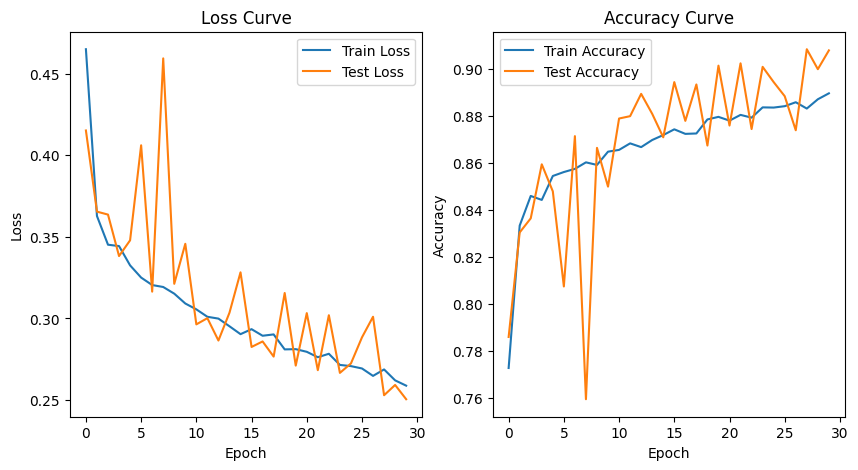

In [72]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(16 * 5 * 5, 60)
        self.fc2 = nn.Linear(60, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the network
net = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
epochs = 30
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Testing loop
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy[-1]:.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [73]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Número total de parámetros de la red neuronal: {total_params}")


Número total de parámetros de la red neuronal: 25574


Como era de esperar, los resultados sun muy moderadamente peores a los de los casos anteriores. Tenemos una precisión que no supera el 0.90, el tiempo de cómputo han sido 30 minutos, no más rápido que en modelos anteriores, la inestabilidad de los valores de test sigue ahí, y además parece que en según que casos acierta por encima de sus posibilidades.

Dicho esto, esta brutal reducción de las imágenes nos ha enseñado que el número de parámetros se podía reducir por aquí. En términos de número de parámetros utilizados si parece ser un modelo eficiente. De todos los creados, el otro modelo que estaba alrededor de los 25000 parámetros, tenía unas predicciones muy inferiores a este.

# Conclusiones

Después de un desarrollo como el de este trabajo, las conclusiones son bastante senzillas de escribir. He empezado usando claramente la fuerza bruta, queriendo añadir muchisimas neuronas, mucha calidad a las imágenes y un número de iteraciones altísimo para conseguir modelos que en muchos casos, no eran ultra precisos (teniendo en cuenta sus dimensiones), eran muy lentos entrenando y se pasaban por mucho de las limitaciones que nos habían impuesto.

Una vez he ido analizando y aumentando poco a poco la complejidad de estos, la cantidad de infromación que le añadía, y ajustando los hiperparámetros, los modelos han ido llegando a valores muy similares y siendo bastante más robustos.

A parte de la lección de no usar la fuerza bruta, también creo importante destacar la dificultad que en muchos casos un Data Scientist se puede encontrar para acabar de optimizar un modelo y llevarlo a unos valores de precisión cercanos a 1. Ni con fuerza bruta, ni precisando poco a poco, he conseguido valores por encima del 0.95 y, la verdad, creando y modificando parámetros, tenía siempre la sensación que cada centésima de precisión me costaba muchísimo de conseguir.

Probablemente, si tuviera que escoger uno de todos los modelos creados, escogería el que tenía las siguientes características:
- 48 neuronas
- Imágenes iniciales de 64 píxeles
- Pooling 2x2
- 30 Epochs
- Learning Rate de 0.0005
- Precision entre 0.92 y 0.93 para los datos de validacion
- Precision entre 0.94 y 0.95 para los datos de entrenamiento

Es el modelo más eficiente, con un entrenamiento relativamente rápido, robusto y además un modelo en el que solo usamos 200000 parámetros.

Por último, si que me gustaría mencionar en las conclusiones un problema recurrente que he tenido a lo largo de toda la entrega: la más que evidente inestabilidad de los resultados con los datos de validación. Realmente he probado prácticamente todo lo que sabía y no he conseguido que en ninguno de los modelos con más de 10 epochs, hubiera una estabilidad entre cada iteracion. En algunos casos he dicho que los valores de precisión se estabilizaban en cierto punto porque parecían seguir una tendencia alrededor de ese valor, pero no me parece óptimo tener estos picos y valles tan prounciados y han aparecido en todos los modelos creados.